# CSAPR example PyDDA single doppler

In [1]:
import pydda
import pyart
from unravel import dealias
%pylab inline
import cartopy.crs as ccrs
from distributed import Client
from dask_jobqueue import SLURMCluster


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



/home/rjackson/.local/lib/python3.6/site-packages/pyart/graph/cm.py:104: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'red' in spec:
/home/rjackson/.local/lib/python3.6/site-packages/pyart/graph/cm_colorblind.py:32: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'red' in spec:
/home/rjackson/anaconda3/envs/pyart-2018/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


Populating the interactive namespace from numpy and matplotlib


In [25]:
xsapr = pyart.io.read('110635.mdv')
xsapr.info()

altitude:
	data: <ndarray of type: float64 and shape: (1,)>
	long_name: Altitude
	standard_name: Altitude
	units: meters
	positive: up
altitude_agl: None
antenna_transition: None
azimuth:
	data: <ndarray of type: float64 and shape: (6120,)>
	units: degrees
	standard_name: beam_azimuth_angle
	long_name: azimuth_angle_from_true_north
	axis: radial_azimuth_coordinate
	comment: Azimuth of antenna relative to true north
elevation:
	data: <ndarray of type: float64 and shape: (6120,)>
	units: degrees
	standard_name: beam_elevation_angle
	long_name: elevation_angle_from_horizontal_plane
	axis: radial_elevation_coordinate
	comment: Elevation of antenna relative to the horizontal plane
fields:
	reflectivity:
		data: <ndarray of type: float32 and shape: (6120, 983)>
		units: dBZ
		standard_name: equivalent_reflectivity_factor
		long_name: Reflectivity
		coordinates: elevation azimuth range
		_FillValue: -9999.0
	specific_differential_phase:
		data: <ndarray of type: float32 and shape: (6120, 983)

In [26]:
display = pyart.graph.RadarDisplay(xsapr)

In [30]:
gate_number = np.tile(np.arange(0, xsapr.ngates), (xsapr.nrays,1))
xsapr.add_field_like('normalized_coherent_power', 'gate_number', gate_number)

In [31]:
gatefilter = pyart.filters.GateFilter(xsapr)
vel_texture = pyart.retrieve.calculate_velocity_texture(xsapr)
xsapr.add_field('velocity_texture', vel_texture, replace_existing=True)
gatefilter.exclude_below('normalized_coherent_power',0.9)
gatefilter.exclude_above('velocity_texture', 4)
gatefilter = pyart.correct.despeckle_field(xsapr, 'reflectivity', gatefilter=gatefilter, size=100)

gatefilter_reflectivity = pyart.filters.GateFilter(xsapr)
gatefilter_reflectivity.exclude_above('gate_number', 950)

In [28]:
xsapr.info()

altitude:
	data: <ndarray of type: float64 and shape: (1,)>
	long_name: Altitude
	standard_name: Altitude
	units: meters
	positive: up
altitude_agl: None
antenna_transition: None
azimuth:
	data: <ndarray of type: float64 and shape: (6120,)>
	units: degrees
	standard_name: beam_azimuth_angle
	long_name: azimuth_angle_from_true_north
	axis: radial_azimuth_coordinate
	comment: Azimuth of antenna relative to true north
elevation:
	data: <ndarray of type: float64 and shape: (6120,)>
	units: degrees
	standard_name: beam_elevation_angle
	long_name: elevation_angle_from_horizontal_plane
	axis: radial_elevation_coordinate
	comment: Elevation of antenna relative to the horizontal plane
fields:
	reflectivity:
		data: <ndarray of type: float32 and shape: (6120, 983)>
		units: dBZ
		standard_name: equivalent_reflectivity_factor
		long_name: Reflectivity
		coordinates: elevation azimuth range
		_FillValue: -9999.0
	specific_differential_phase:
		data: <ndarray of type: float32 and shape: (6120, 983)

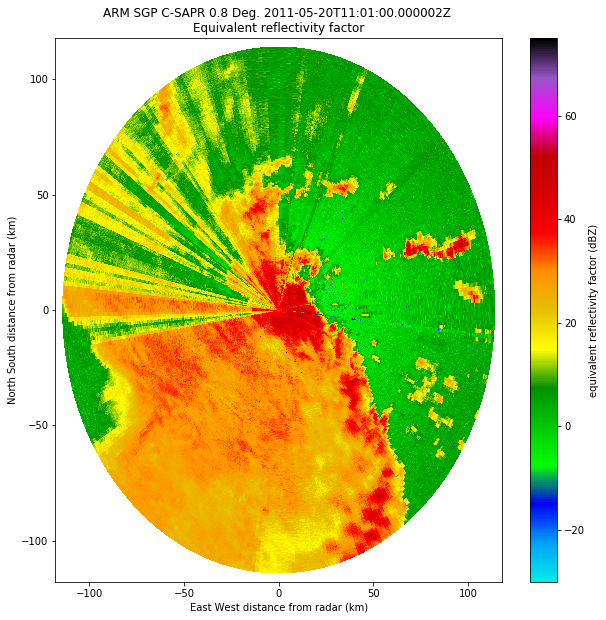

In [32]:
plt.figure(figsize=(10,10))
display.plot_ppi('reflectivity', gatefilter=gatefilter_reflectivity, sweep=0)

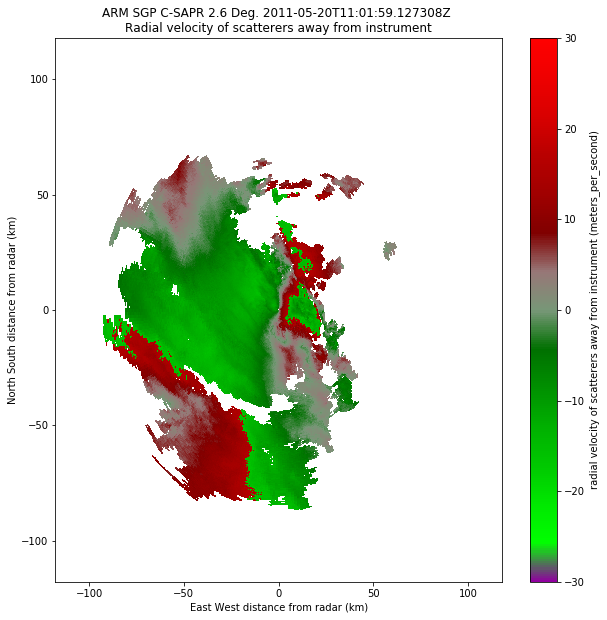

In [17]:
plt.figure(figsize=(10,10))
display.plot_ppi('velocity', gatefilter=gatefilter, sweep=3, cmap='pyart_NWSVel')

In [7]:
dir(dealias)

['__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'continuity',
 'count_proc',
 'dealiasing_process_2D',
 'filtering',
 'find_reference',
 'initialisation',
 'np',
 'process_3D',
 'time',
 'traceback']

In [25]:
pyart.correct.dealias_region_based?

In [33]:
dealiased_vel = dealias.process_3D(xsapr, gatefilter=gatefilter, velname='velocity')
xsapr.add_field_like('velocity','corrected_velocity', dealiased_vel, replace_existing=True)

In [10]:
xsapr.add_field_like?

In [30]:
dealiased_vel = pyart.correct.dealias_region_based(xsapr, gatefilter=gatefilter, rays_wrap_around=True,
                                                   centered=False)
xsapr.add_field('corrected_velocity', dealiased_vel, replace_existing=True)

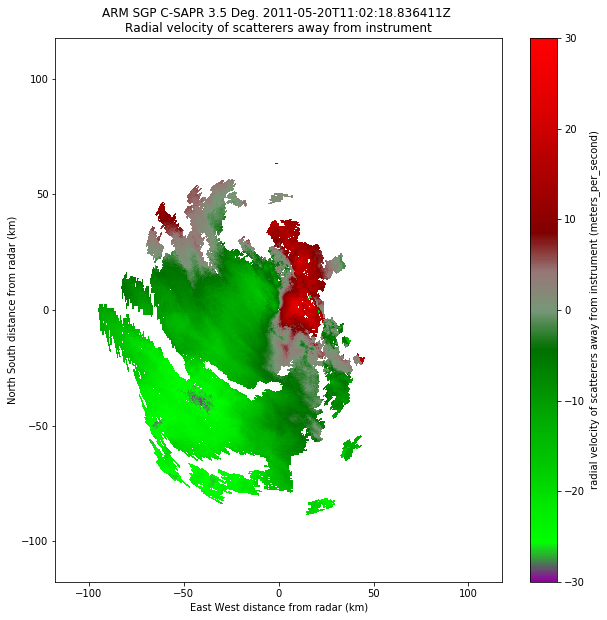

In [34]:
n_sweeps = xsapr.nsweeps
plt.figure(figsize=(10,10))
display.plot_ppi('corrected_velocity', sweep=4, cmap='pyart_NWSVel', vmin=-30, vmax=30)

In [35]:
def grid_radar(radar, grid_shape=(20, 301, 301), xlim=(-150000, 150000),
               ylim=(-150000, 150000), zlim=(1000, 20000), bsp=1.0, 
               min_radius=750, h_factor=1.0, nb=1.0,
               fields=['DT', 'VT'], origin=None, gatefilter=None):
    bt = time.time()
    radar_list = [radar]
    if origin is None:
        origin = (radar.latitude['data'][0],
                  radar.longitude['data'][0])
    grid = pyart.map.grid_from_radars(
        radar_list, grid_shape=grid_shape,
        grid_limits=(zlim, ylim, xlim),
        grid_origin=origin, fields=fields,
        weighting_function='Cressman',
        gridding_algo='map_gates_to_grid',
        h_factor=h_factor,
        min_radius=min_radius,
        bsp=bsp,
        nb=nb,
        gatefilter=gatefilter)
    print(time.time() - bt, 'seconds to grid radar')
    return grid

In [36]:
the_grid = grid_radar(xsapr, grid_shape=(61, 451, 451), xlim=(-125000, 125000), ylim=(-125000, 125000),
                      zlim=(0, 15000.), min_radius=250, h_factor=1.0, fields=['reflectivity'],
                      gatefilter=gatefilter_reflectivity)
the_grid2 = grid_radar(xsapr, grid_shape=(61, 451, 451), xlim=(-125000, 125000), ylim=(-125000, 125000),
                      zlim=(0, 15000.), min_radius=250, h_factor=1.0, fields=['corrected_velocity'],
                      gatefilter=gatefilter)
the_grid.fields["corrected_velocity"] = the_grid2.fields["corrected_velocity"].copy()

12.936769485473633 seconds to grid radar
12.07813811302185 seconds to grid radar


In [44]:
winds[0].fields["corrected_velocity"]["data"].shape

(61, 451, 451)

In [66]:
display = pyart.graph.GridMapDisplay(the_grid)

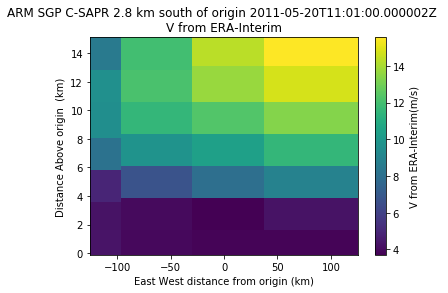

In [68]:
display.plot_latitudinal_level("V_erainterim", 220)

In [37]:
pyart.io.write_grid('CSAPRgrid2.nc', the_grid)

In [38]:
the_grid = pydda.constraints.make_constraint_from_era_interim(the_grid)

Download ERA Interim data...
2019-03-22 10:47:26 ECMWF API python library 1.5.0
2019-03-22 10:47:26 ECMWF API at https://api.ecmwf.int/v1
2019-03-22 10:47:27 Welcome Robert Jackson
2019-03-22 10:47:28 In case of problems, please check https://confluence.ecmwf.int/display/WEBAPI/Web-API+Troubleshooting or contact servicedesk@ecmwf.int
2019-03-22 10:47:28 In case of delays, please check  service activity page https://apps.ecmwf.int/webapi-activity/
2019-03-22 10:47:28 Request submitted
2019-03-22 10:47:28 Request id: 5c950393bcd319dff5058d46
2019-03-22 10:47:28 Request is submitted
2019-03-22 10:47:30 Request is queued
Calling 'nice mars /tmp/6d/0f/tmp-_marsPbXVrs.req'
mars - WARN -
mars - WARN - From 29 January 2019 10AM (UTC) MARS uses the interpolation
mars - WARN - provided by the MIR library. For more details, see
mars - WARN - https://confluence.ecmwf.int/display/UDOC/MARS+interpolation+with+MIR
mars - WARN -
PPDIR is /var/tmp/ppdir/x86_64
mars - INFO   - 20190322.154908 - Welcome 

In [39]:
pyart.io.write_grid('CSAPR_with_era_interim.nc', the_grid)

In [40]:
the_grid = pyart.io.read_grid('CSAPR_with_era_interim.nc')

In [209]:
from dask_jobqueue import SLURMCluster
cluster = SLURMCluster(cores=2, project='rainfall', walltime='1:00:00', 
                       processes=2, memory='128GB')

cluster.scale(4) 

In [210]:
client = Client(cluster)

In [219]:
client

Client Scheduler: tcp://140.221.70.5:33915 Dashboard: http://140.221.70.5:36018/status,Cluster Workers: 4 Cores: 4 Memory: 256.00 GB


In [40]:
cluster.scale(10)

In [41]:
the_grid.fields["corrected_velocity"]["data"].max()
weights = np.where(~the_grid.fields["corrected_velocity"]["data"].mask, 1, 0)
vrs = the_grid.fields["corrected_velocity"]["data"]
sum_Vr = np.sum(np.square(vrs*weights))/np.sum(weights)
sum_Vr

215.80000774204333

In [71]:
len([the_grid])

1

In [42]:
u_init = the_grid.fields["U_erainterim"]["data"]
v_init = the_grid.fields["V_erainterim"]["data"]
w_init = the_grid.fields["W_erainterim"]["data"]

winds = pydda.retrieval.get_dd_wind_field([the_grid], u_init, v_init, w_init, 
                                          Cmod=5e-6, Co=1.0, Cx=1e-4, Cy=1e-4, model_fields=["erainterim"],
                                          Cm=100.0)

Starting solver 
rmsVR = 215.80000774204333
Total points:2152224.0
| Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel | Max w  
|4153.6591|  25.7641| 597.4083|   0.0000|   0.0000| 118.4292|   1.6567
Norm of gradient: 0.04314117993681753
Iterations before filter: 10
| Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel | Max w  
|2313.5218|  46.8530| 805.5673|   0.0000|   0.0000| 278.4551|   4.4619
Norm of gradient: 0.03980977784933626
Iterations before filter: 20
| Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel | Max w  
|1833.5421|  46.6300| 245.4393|   0.0000|   0.0000| 388.3045|   4.8310
Norm of gradient: 0.015571302723410015
Iterations before filter: 30
| Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel | Max w  
|1335.5886|  49.3370| 270.3415|   0.0000|   0.0000| 512.5611|   5.8249
Norm of gradient: 0.008820433594965817
Iterations before filter: 40
| Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel | Max w  
|1060.6212|  50.3705| 203.7140|   

/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


Iterations after filter: 1
Iterations after filter: 2
Done! Time = 1506.6


In [60]:
rad_range = np.sqrt(winds[0].point_x["data"]**2 + winds[0].point_y["data"]**2)
winds[0].fields["reflectivity"]["data"] = the_grid.fields["reflectivity"]["data"]
winds[0].fields["reflectivity"]["data"] = np.ma.masked_where(rad_range > 115000., winds[0].fields["reflectivity"]["data"])
winds[0].fields["corrected_reflectivity"] = winds[0].fields["reflectivity"].copy()
winds[0].fields["corrected_reflectivity"]["data"] = np.ma.masked_where(
    np.logical_or(winds[0].fields["corrected_velocity"]["data"].mask, winds[0].fields["reflectivity"]["data"].mask),
                                                                       winds[0].fields["corrected_reflectivity"]["data"])
# Mask out all data > 120 km away


/home/rjackson/anaconda3/envs/pyart-2018/lib/python3.6/site-packages/pydda-0.3.1-py3.6.egg/pydda/vis/streamline_plot.py:460: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  np.linspace(grid_lon.min(), grid_lon.max(), num_tenths), 1)
/home/rjackson/anaconda3/envs/pyart-2018/lib/python3.6/site-packages/pydda-0.3.1-py3.6.egg/pydda/vis/streamline_plot.py:463: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  np.linspace(grid_lat.min(), grid_lat.max(), num_tenths), 1)


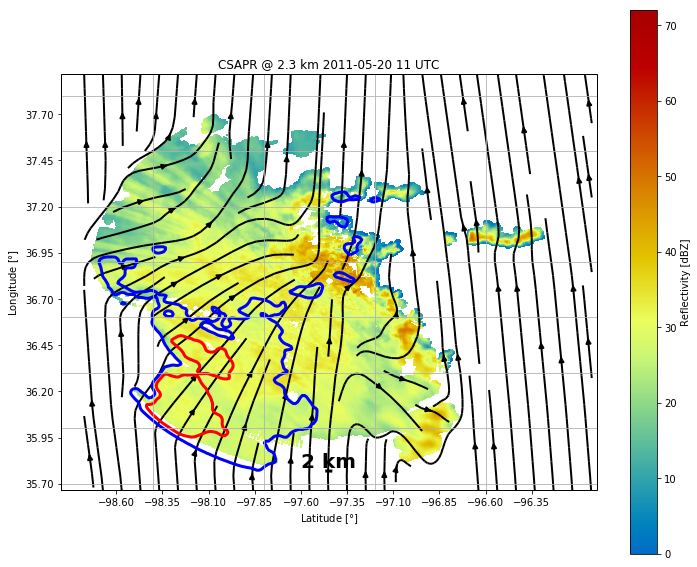

In [64]:
fig = plt.figure(figsize=(12,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax = pydda.vis.plot_horiz_xsection_streamlines_map(winds
                                          , ax=ax, level=8, background_field='corrected_reflectivity',
                                           vmin=0, vmax=72, 
                                           cmap='pyart_HomeyerRainbow')
ax.set_title('CSAPR @ 2.3 km 2011-05-20 11 UTC')
ax.set_xticks(np.arange(-98.6, -96.3, 0.25))
ax.set_yticks(np.arange(35.7, 37.9, 0.25))
#ax.set_xlim([-97.1, -96.95])
#ax.set_ylim([36.45, 36.6])
rlat = winds[0].radar_latitude["data"]
rlon = winds[0].radar_longitude["data"]
wind_speed = np.sqrt(winds[0].fields["u"]["data"]**2 + winds[0].fields["v"]["data"]**2)
wind_speed = wind_speed.filled(np.nan)
lons = winds[0].point_longitude["data"]
lats = winds[0].point_latitude["data"]
cs = ax.contour(lons[8, ::2, ::2], lats[8, ::2, ::2], wind_speed[8, ::2, ::2], levels=[10, 20], 
                linewidths=3, colors=['b', 'r', 'k'])
# SGP site = 36° 36′ 18″ N, 97° 29′ 6″ W
sgp_lat = 36.+36./60.+18./3600.
sgp_lon = -(97.+ 29/60 + 6/3600)
#ax.text(rlon, rlat, 'CSAPR', fontsize=20, fontweight='bold')
#ax.text(sgp_lon, sgp_lat, 'SGP CF', fontsize=20, fontweight='bold')
scale_bar(ax, 2, linewidth=3, location=(0.5, 0.05))

In [21]:
pydda.vis.plot_horiz_xsection_streamlines_map?

In [47]:
del client, cluster

In [224]:
cluster.stop_all_jobs()

In [55]:
pyart.io.write_grid('ddop_csapr.nc', winds[0])

In [2]:
winds = [pyart.io.read_grid('ddop_csapr.nc')]

In [6]:
def scale_bar(ax, length, location=(0.5, 0.05), linewidth=3, fontweight='bold', fontsize=20):
    """
    ax is the axes to draw the scalebar on.
    location is center of the scalebar in axis coordinates ie. 0.5 is the middle of the plot
    length is the length of the scalebar in km.
    linewidth is the thickness of the scalebar.
    """
    #Projection in metres, need to change this to suit your own figure
    utm = ccrs.UTM(14)
    #Get the extent of the plotted area in coordinates in metres
    x0, x1, y0, y1 = ax.get_extent(utm)
    #Turn the specified scalebar location into coordinates in metres
    sbcx, sbcy = x0 + (x1 - x0) * location[0], y0 + (y1 - y0) * location[1]
    #Generate the x coordinate for the ends of the scalebar
    bar_xs = [sbcx - length * 500, sbcx + length * 500]
    #Plot the scalebar
    ax.plot(bar_xs, [sbcy, sbcy], transform=utm, color='k', linewidth=linewidth)
    #Plot the scalebar label
    ax.text(sbcx, sbcy, str(length) + ' km', transform=utm,
            horizontalalignment='center', verticalalignment='bottom', fontweight=fontweight, 
            fontsize=fontsize)